In [75]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np

In [76]:
# Импорт библиотек для построения и визуализации графов
import networkx as nx
import matplotlib.pyplot as plt

In [77]:
# Импорт пакетов для выполнения ассоциативных правил
from mlxtend.preprocessing import TransactionEncoder #для кодирования транзакций
from mlxtend.frequent_patterns import apriori #для построения модели apriori
from mlxtend.frequent_patterns import association_rules #для поиска ассоциативных правил
from sklearn.decomposition import PCA #для построения линейной проекции
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

In [78]:
#Импорт входных данных из указанной директории
dataf = pd.read_csv("/home/ilumi/my/stud/analyse/assc_TRANSACTION.csv")
dataf.head(10) #вывод первых строк

,CUSTOMER,TIME,PRODUCT
0,0,0,hering
1,0,1,corned_b
2,0,2,olives
3,0,3,ham
4,0,4,turkey
5,0,5,bourbon
6,0,6,ice_crea
7,1,0,baguette
8,1,1,soda
9,1,2,hering


**Вопрос 1.**

Определите (написав соответствующий код) сколько различных значений принимают переменные Product и Customer.

In [79]:
#Вопрос 1
dataf.PRODUCT.nunique() #Различные значения переменной PRODUCT

20

In [80]:
dataf.CUSTOMER.nunique() #Различные значения переменной CUSTOMER

1001

**Вопрос 2.**

Найти частые эпизоды с ограничением на размер правила равным 4 с использованием алгоритма и порога на поддержку согласно варианту.

**Вариант 7: Apriori, 5%**

In [91]:
#Формирование списков транзакций
transactions = dataf.groupby('CUSTOMER').aggregate({"PRODUCT":list}).values[:, 0]
# GROUPBY данные группируются по 20 покупателям, выволятся купленные продукты 
# отдельным пркупателем

#values[:, 0] - даст все значения в столбе 0 (из всех строк)


In [96]:
transactions[0]

['hering', 'corned_b', 'olives', 'ham', 'turkey', 'bourbon', 'ice_crea']

In [99]:
#Модель Apriori, размер правила 4, порог на подержку 5%
def get_FreqItems (trans, model = "apriori"):
    #Кодирование транзакций
    te = TransactionEncoder()
    te_aray = te.fit_transform(trans) #подогнать модель к данным, а затем преобразовать данные в соответствии с подобранной моделью
    df = pd.DataFrame(te_aray, columns = te.columns_)
    return apriori(df, min_support = 0.05, max_len = 4, use_colnames = True)

FreqIt = get_FreqItems (transactions, model = "apriori")

FreqIt.head()

,support,itemsets
0,0.313686,(apples)
1,0.304695,(artichok)
2,0.362637,(avocado)
3,0.391608,(baguette)
4,0.073926,(bordeaux)


**Вопрос 3.**

Найдите самый большой (где больше всего элементов) частый эпизод, содержащий продукт
согласно вашему варианту. Какая у него поддержка?
Продукт - ice_crea.

In [83]:
x1 = FreqIt
max = x1.sort_values(by = "itemsets", ascending = False) #сортировка по убыванию
max.head()

#support = 0,099, т.е. примерно 9,9%

,support,itemsets
180,0.095904,"(peppers, apples, avocado)"
253,0.126873,"(olives, turkey, bourbon)"
251,0.098901,"(ice_crea, turkey, bourbon)"
250,0.107892,"(ice_crea, bourbon, olives)"
249,0.062937,"(olives, bourbon, hering)"


**Вопрос 4.** 

Построить ассоциативные правила с порогом на достоверность 40%. 
Найти правило с максимальным лифтом, указать числовые показатели поддержки, достоверности и подъема.

In [113]:
#Ассоциативные правила, модель Apriori
x = association_rules(FreqIt, metric = "confidence", min_threshold = 0.4)
x.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(apples),(avocado),0.313686,0.362637,0.138861,0.442675,1.220710,0.025107,1.143611
1,(apples),(baguette),0.313686,0.391608,0.146853,0.468153,1.195462,0.024011,1.143922
2,(apples),(corned_b),0.313686,0.390609,0.150849,0.480892,1.231132,0.028320,1.173918
3,(apples),(hering),0.313686,0.485514,0.156843,0.500000,1.029835,0.004544,1.028971
4,(apples),(olives),0.313686,0.472527,0.158841,0.506369,1.071619,0.010616,1.068557


In [115]:
#поиск правила с максимальным лифтом
x.loc[x['consequents'] == {'ice_crea'}].sort_values(['lift'], ascending = False).head(1)

#support - 11,6%: в 11% транзакций coke, sardines, chicken и ice_crea присутствуют вместе
#confidence - 99,4%: при покупке coke, sardines, chicken с вероятностью 99% будет куплено ice_crea
#lift - 3,2%: мера значимости правила, правило значимо, т.к. больше 1. Эти продукты в транзакциях чаще встречаются вместе

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
818,"(coke, sardines, chicken)",(ice_crea),0.116883,0.312687,0.115884,0.991453,3.170749,0.079336,80.415584


**Вопрос 5.** 

Построить ориентированный граф: вершины - элементы правила, цвет/размер - поддержка элемента, дуги - импликации, вес дуги - достоверность.

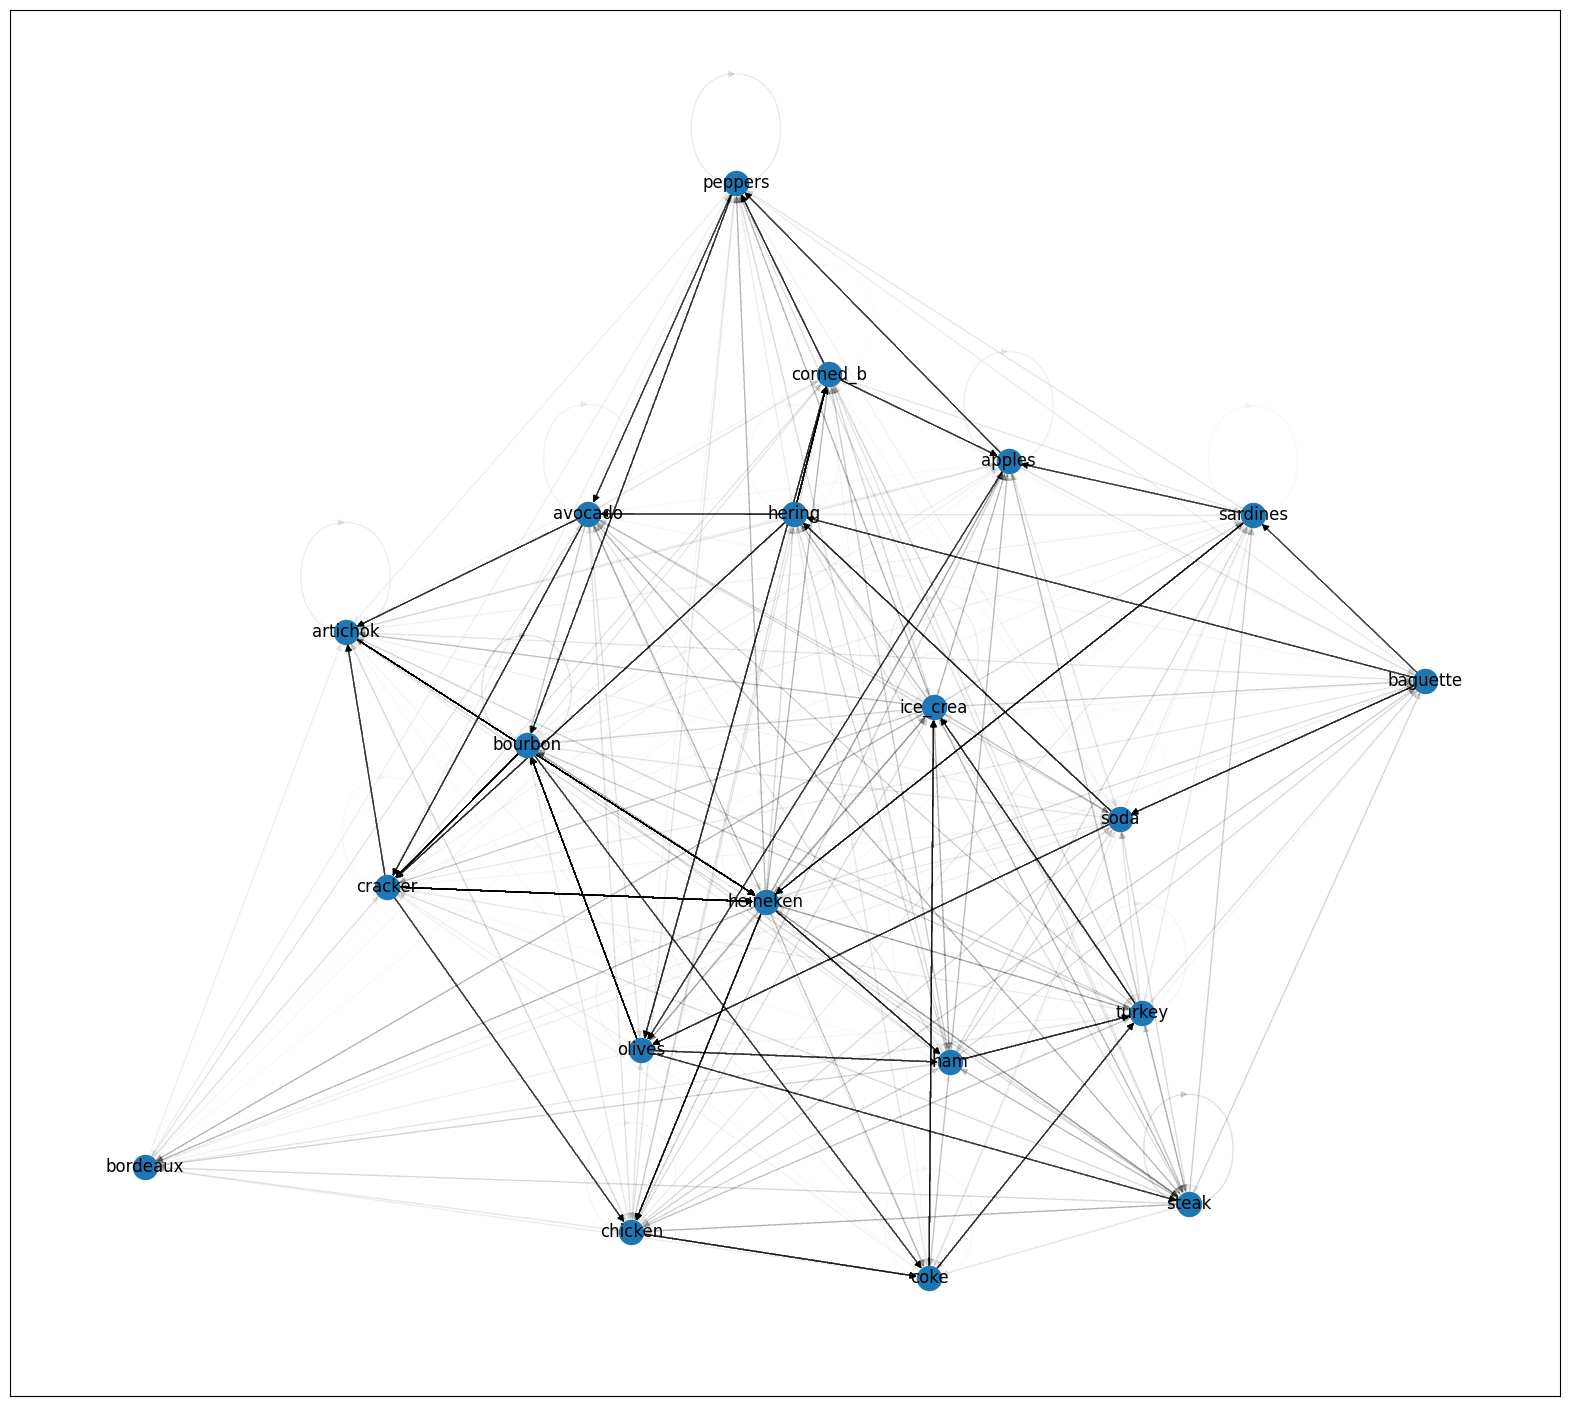

In [85]:
#Построение ориентированного графа транзакций
G = nx.MultiDiGraph()
for t in transactions:
    for i in range(len(t) - 1):
        G.add_edge(t[i], t[i+1])

#Визуализация графа
plt.figure(figsize=(20, 18))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos)
edges = nx.draw_networkx_edges(G, pos, alpha=0.01)
labels = nx.draw_networkx_labels(G, pos)

In [86]:
nx.closeness_centrality(G)

#Близость центральности — полезная мера, которая оценивает, насколько быстрым будет поток информации через данный узел к другим узлам. Центральность близости измеряет, насколько короткими являются кратчайшие пути от узла i ко всем узлам.
#продукт 
#ice_crea - 1.0

{'hering': 0.9047619047619048,
 'corned_b': 1.0,
 'olives': 0.95,
 'ham': 1.0,
 'turkey': 0.9047619047619048,
 'bourbon': 1.0,
 'ice_crea': 1.0,
 'baguette': 0.8636363636363636,
 'soda': 1.0,
 'cracker': 0.9047619047619048,
 'heineken': 0.8636363636363636,
 'avocado': 1.0,
 'artichok': 1.0,
 'sardines': 0.95,
 'coke': 1.0,
 'peppers': 0.95,
 'apples': 1.0,
 'steak': 1.0,
 'chicken': 1.0,
 'bordeaux': 0.6129032258064516}

**Вопрос 7.**

Построить числовую матрицу со счетчиком числа покупок: клиенты по строкам, продукты по столбцам.

In [87]:
assoc = dataf.groupby("CUSTOMER")["PRODUCT"].value_counts().unstack(fill_value = 0)
assoc

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
CUSTOMER,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
997,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
998,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,1,0,0


**Вопрос 8.**

Построить линейную проекцию набора данных на плоскость (2 компоненты). Метод - PCA.

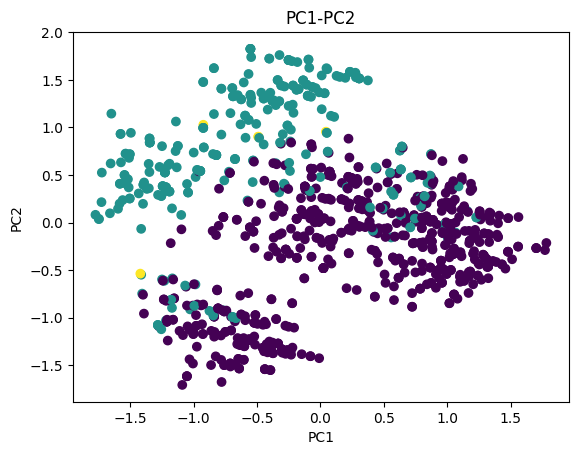

In [88]:
N = 2
pca = PCA(n_components = N)
features = pca.fit_transform(assoc)
plt.scatter(features[:, 0], features[:, 1], c = assoc["ice_crea"])
plt.title("PC1-PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
pass

Text(0, 0.5, 'PC2')

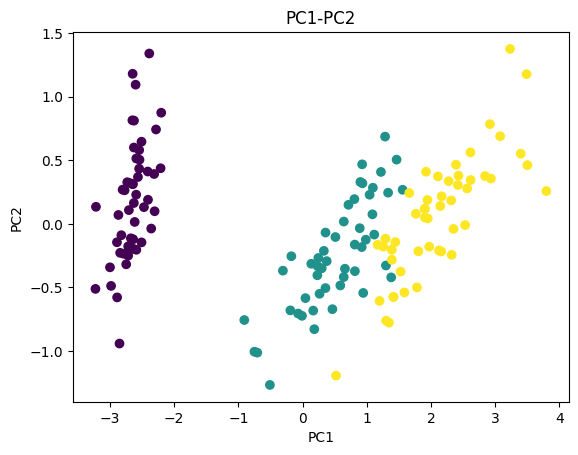

In [89]:
iris = load_iris()
X = iris.data
Y = iris.target
features = PCA(n_components = 2).fit_transform(X)
plt.scatter(features[:, 0], features[:, 1], c = Y)
plt.title("PC1-PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")


**Вопрос 9.**

Построить неоинейную проекцию, цветом указать транзакции ice_crea.

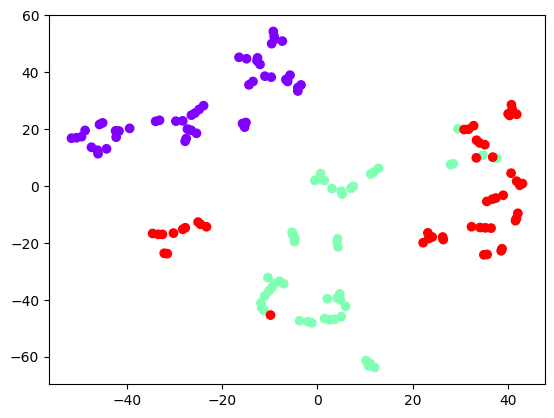

In [90]:
iris = load_iris()
X = iris.data
Y = iris.target
embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = 3).fit_transform(X)
plt.scatter(*embedded.T, c = Y, cmap = "rainbow")